# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

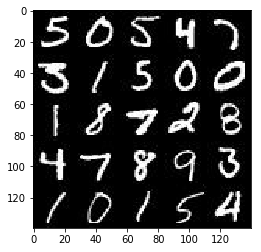

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

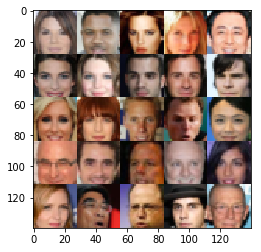

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim),  name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*112)
        #print(x1.get_shape())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())        
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())                
        # 8x8x256 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape())        

        
        out = tf.tanh(logits)
        
        return out
    
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())        
        
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape())        
        
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        out_channel_dim = 3
    elif data_image_mode == "L":
        out_channel_dim = 1
        
    n_images=9
    steps=0
    print_every = 10
    show_every = 100
    print(data_shape)
    print(z_dim)
    print(data_image_mode)

    
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print(input_real.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                
                if steps % show_every == 0:                
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
150
L
(?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.7380... Generator Loss: 2.7303
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.3608
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 5.1490... Generator Loss: 6.7002
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.4738
Epoch 1/2... Discriminator Loss: 0.7860... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 2.2929
Epoch 1/2... Discriminator Loss: 0.4577... Generator Loss: 2.7805


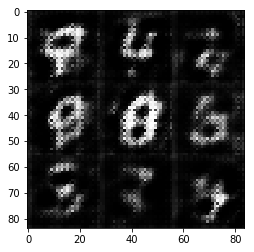

Epoch 1/2... Discriminator Loss: 0.1771... Generator Loss: 2.2555
Epoch 1/2... Discriminator Loss: 0.0812... Generator Loss: 3.1831
Epoch 1/2... Discriminator Loss: 18.7006... Generator Loss: 19.0609
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 3.5891... Generator Loss: 5.0824
Epoch 1/2... Discriminator Loss: 0.4159... Generator Loss: 1.4556
Epoch 1/2... Discriminator Loss: 2.1358... Generator Loss: 6.5562
Epoch 1/2... Discriminator Loss: 0.2148... Generator Loss: 2.2367
Epoch 1/2... Discriminator Loss: 5.4350... Generator Loss: 7.5791
Epoch 1/2... Discriminator Loss: 0.6458... Generator Loss: 2.8450


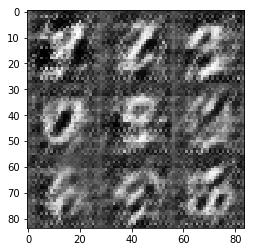

Epoch 1/2... Discriminator Loss: 5.9279... Generator Loss: 7.8856
Epoch 1/2... Discriminator Loss: 1.7146... Generator Loss: 0.2797
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 2.4672... Generator Loss: 0.1292
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 1.7142
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 0.4035


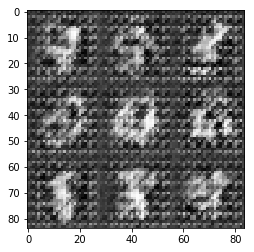

Epoch 1/2... Discriminator Loss: 0.6186... Generator Loss: 1.7626
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 2.8895... Generator Loss: 6.5974
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 1.6584
Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 0.1969... Generator Loss: 2.1800
Epoch 1/2... Discriminator Loss: 0.1195... Generator Loss: 2.5663
Epoch 1/2... Discriminator Loss: 0.0395... Generator Loss: 4.8170
Epoch 1/2... Discriminator Loss: 0.0647... Generator Loss: 3.2805
Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 3.5141


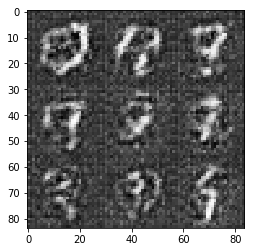

Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 1.5327
Epoch 1/2... Discriminator Loss: 0.5992... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.3604
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 1.5886
Epoch 2/2... Discriminator Loss: 0.6717... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 0.2949... Generator Loss: 1.6314
Epoch 2/2... Discriminator Loss: 0.1605... Generator Loss: 2.2354


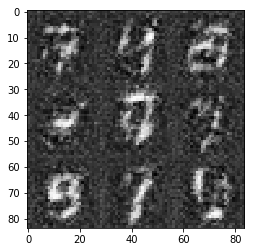

Epoch 2/2... Discriminator Loss: 0.0278... Generator Loss: 5.2719
Epoch 2/2... Discriminator Loss: 0.0606... Generator Loss: 3.6782
Epoch 2/2... Discriminator Loss: 0.0396... Generator Loss: 4.1657
Epoch 2/2... Discriminator Loss: 0.0505... Generator Loss: 3.9374
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 4.6763
Epoch 2/2... Discriminator Loss: 0.0240... Generator Loss: 4.6188
Epoch 2/2... Discriminator Loss: 0.0292... Generator Loss: 4.0997
Epoch 2/2... Discriminator Loss: 0.0157... Generator Loss: 5.2253
Epoch 2/2... Discriminator Loss: 0.0247... Generator Loss: 4.4711
Epoch 2/2... Discriminator Loss: 0.0672... Generator Loss: 3.1473


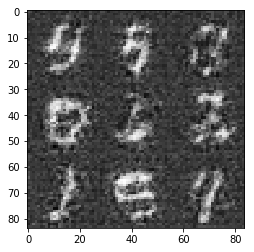

Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 3.2131
Epoch 2/2... Discriminator Loss: 1.8438... Generator Loss: 0.2504
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.8945
Epoch 2/2... Discriminator Loss: 0.7665... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 0.7389... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.1292... Generator Loss: 4.1487
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 1.4531
Epoch 2/2... Discriminator Loss: 0.3101... Generator Loss: 1.6590
Epoch 2/2... Discriminator Loss: 0.1959... Generator Loss: 2.1627
Epoch 2/2... Discriminator Loss: 0.1078... Generator Loss: 2.8250


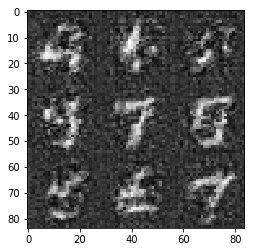

Epoch 2/2... Discriminator Loss: 0.3114... Generator Loss: 1.6515
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 2.8972
Epoch 2/2... Discriminator Loss: 0.0893... Generator Loss: 2.9494
Epoch 2/2... Discriminator Loss: 0.3006... Generator Loss: 1.6619
Epoch 2/2... Discriminator Loss: 0.0804... Generator Loss: 3.0085
Epoch 2/2... Discriminator Loss: 0.0695... Generator Loss: 3.3335
Epoch 2/2... Discriminator Loss: 0.0900... Generator Loss: 2.9961
Epoch 2/2... Discriminator Loss: 0.0936... Generator Loss: 2.8927
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 5.8253
Epoch 2/2... Discriminator Loss: 0.0118... Generator Loss: 5.1523


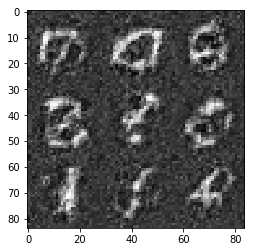

Epoch 2/2... Discriminator Loss: 0.0154... Generator Loss: 5.4488
Epoch 2/2... Discriminator Loss: 0.0102... Generator Loss: 5.5797
Epoch 2/2... Discriminator Loss: 0.0323... Generator Loss: 3.9969
Epoch 2/2... Discriminator Loss: 0.0062... Generator Loss: 6.2532
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 4.2297
Epoch 2/2... Discriminator Loss: 0.0097... Generator Loss: 5.6262
Epoch 2/2... Discriminator Loss: 0.0118... Generator Loss: 6.2164
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 1.5369
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 3.2018
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.2917


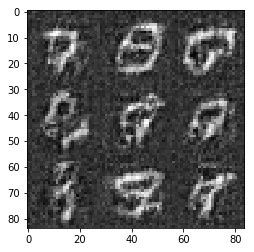

Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 4.8490
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 2.4773
Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 0.8331


In [12]:
batch_size = 128
z_dim = 150
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
150
RGB
(?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 4.0489... Generator Loss: 0.2127
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 2.1181
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.8314... Generator Loss: 0.2416
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 3.3803
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 2.1895
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.0394


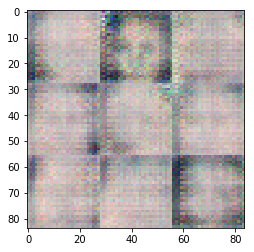

Epoch 1/1... Discriminator Loss: 9.8624... Generator Loss: 0.0015
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9779


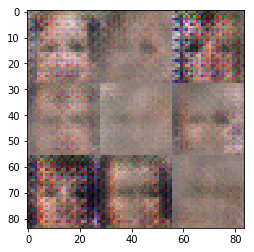

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.2361... Generator Loss: 2.3511


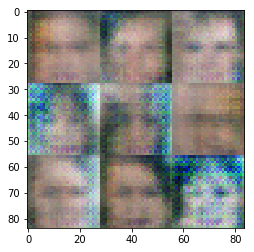

Epoch 1/1... Discriminator Loss: 0.7391... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.2516
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 2.5791
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 2.6259


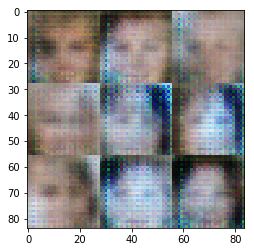

Epoch 1/1... Discriminator Loss: 4.4647... Generator Loss: 4.5565
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 0.2957... Generator Loss: 2.4108
Epoch 1/1... Discriminator Loss: 0.0235... Generator Loss: 4.3436
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 0.1856... Generator Loss: 4.3251
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 4.5852
Epoch 1/1... Discriminator Loss: 2.6086... Generator Loss: 0.1511
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 2.7579
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 0.7165


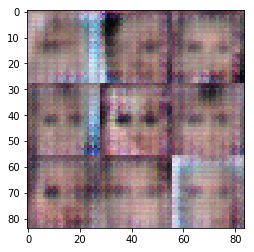

Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 1.7086
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 3.8416
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 6.9099
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 5.0475
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 2.0035
Epoch 1/1... Discriminator Loss: 3.6318... Generator Loss: 0.0651


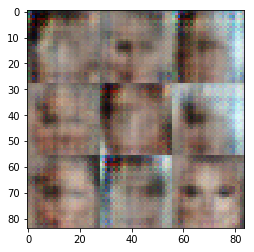

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 2.5908... Generator Loss: 2.6721
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 2.2270
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 1.4073
Epoch 1/1... Discriminator Loss: 2.7952... Generator Loss: 4.1668
Epoch 1/1... Discriminator Loss: 1.8229... Generator Loss: 0.2666
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 2.5471


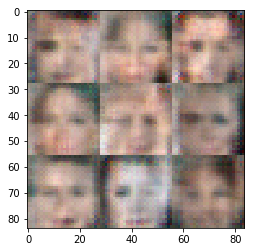

Epoch 1/1... Discriminator Loss: 2.3485... Generator Loss: 2.6366
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.6251
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.6283... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.4305
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.9137


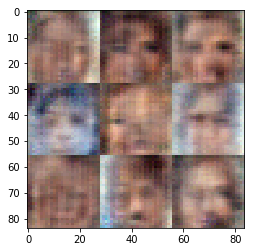

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8862


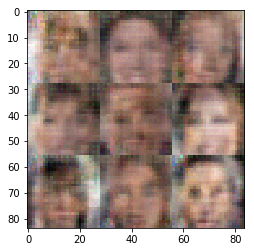

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 1.1354
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7275


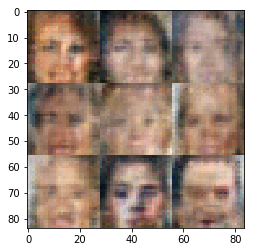

Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9264


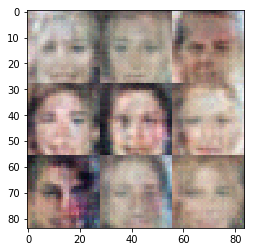

Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.8440... Generator Loss: 1.7169
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6206


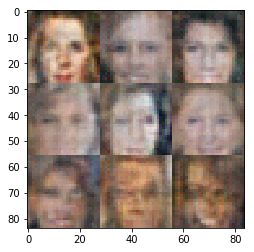

Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.3309
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 0.9801


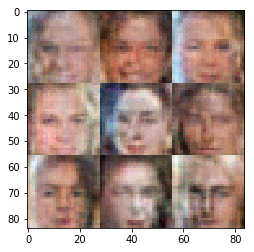

Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.4106
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.9698
Epoch 1/1... Discriminator Loss: 2.4743... Generator Loss: 2.1147
Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 0.2870
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.4568


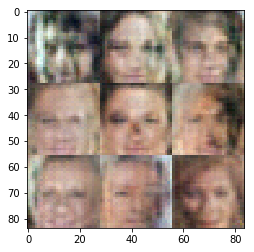

Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.3425
Epoch 1/1... Discriminator Loss: 2.0716... Generator Loss: 2.5753
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.2850


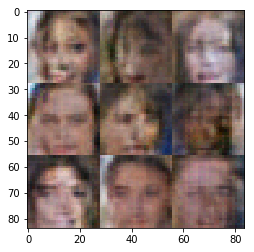

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.2334
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.4979


In [13]:
batch_size = 128
z_dim = 150
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.